# IRASA

#### Notes

- IRASA seems to perform well when there are a few sinusoids added to the aperiodic component where the frequencies of those sinusoids are sufficiently different, e.g. well-spaced in the frequency range.
    - When the frequencies are close to one another, IRASA does not perform as well.

- Lower frequency sinusoids also seem to negatively impact IRASA's estimation.

- IRASA's behavior seems to be stable across different values of $\chi \in (-3, 0)$.

- In the context of a signal with a central frequency and aperiodic noise, IRASA is not robust to the central frequency's relative height or the bandwidth. 

- Interestingly, for knee signals without an aperiodic component, IRASA's estimate for the aperiodic PSD does feature a knee but it's often the wrong shape. The error in estimating both exponents of the knee is on average between 0.5 and 0.8.
    - For the Lorenztian given by 
    $$ \frac{1}{\omega^{\chi_1}(\omega^{\chi_2} + k)},$$
    IRASA performs the worst when $\chi_1 > \chi_2$ and $\chi_2$ is near zero. In this context, the PSD is visually similar to a powerlaw and does not feature a knee.

In [24]:
import fractions
from time import time
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from scipy import signal
from scipy.linalg import norm

from neurodsp.sim import sim_combined
from neurodsp.sim import sim_knee, sim_peak_oscillation
from neurodsp.spectral import compute_spectrum, trim_spectrum
from neurodsp.utils.data import create_times
from neurodsp.plts import plot_time_series, plot_power_spectra
from neurodsp.utils.norm import normalize_sig
from neurodsp.aperiodic import compute_irasa, fit_irasa

In [2]:
# Import functions from temporary file (used for cleanup)
from temp import *

## Settings

In [3]:
# Parameter ranges
FS_RANGE = np.arange(150, 1060, 100, dtype='int')
F_RANGE = (1, 50)
FREQS = np.round(np.linspace(*F_RANGE, num=25))
CHIS = -1 * np.arange(0, 3, 0.25)   # Use negative values per NeuroDSP convention.

# Static constants
N_SECONDS = 10
FS = 10**3
TIMES = create_times(N_SECONDS, FS)
NUM_TRIALS = 10

## Experiment 1: No Oscillations

To start, we compare how well IRASA does at estimating the power law exponent when there are no oscillations. 

We compare this to the modified IRASA where we downsample the power spectrum at logarithmically spaced frequencies and look at how the error behaves as a function of the sampling rate. 

We choose the minimal sampling rate to be at least 3 TIMES that of the maximal frequency in the frequency range, since IRASA seems to perform very poorly when the maximum of the frequency range is close to the Nyquist frequency. 

Further, we look at the average error and the variance of the error across many trials since the results of each trial are a function of the draw of spectrally rotated noise.

In [4]:
# Configure the dataframes
parameter_grid = list(product(CHIS, FS_RANGE, range(NUM_TRIALS)))
num_rows = len(parameter_grid)
columns = ['chi', 'fs', 'trial', 'chi_err']
df = pd.DataFrame(data=np.zeros((num_rows, len(columns))), columns=columns)
df[columns[:-1]] = parameter_grid
df_log = pd.DataFrame(data=np.zeros((num_rows, len(columns))), columns=columns)
df_log[columns[:-1]] = parameter_grid

In [5]:
# Set random seed
np.random.seed(0)

In [6]:
# Run the experiment
tic = time()
for fs, chi, trial_idx in product(FS_RANGE, CHIS, range(NUM_TRIALS)):
    irasa_params = {'fs' : fs, 'f_range' : F_RANGE}
    sim_components = {'sim_powerlaw': {'exponent' : chi}}
    sig = sim_combined(N_SECONDS, fs, sim_components)

    # Compute aperiodic component using IRASA
    freqs_irasa, psd_ap, psd_pe = compute_irasa(sig, **irasa_params)

    # Fit using all frequency data and using subsampled log-spaced frequencies
    fit_off, fit_exp = fit_irasa(freqs_irasa, psd_ap)
    fit_off_log, fit_exp_log = fit_irasa_logspace(freqs_irasa, psd_ap)
    
    loc_mask = (df['chi'] == chi) & (df['fs'] == fs) & (df['trial'] == trial_idx)
    df.loc[loc_mask, 'chi_err'] = fit_exp - chi
    df_log.loc[loc_mask, 'chi_err'] = fit_exp_log - chi
toc = time()
print(f"{toc-tic:.2f} seconds")

33.05 seconds


In [7]:
# Make a dataframe of average errors and keep track of the variances as well
mean_var_df = df.groupby(by=['chi', 'fs']).agg({'chi_err': ['mean', 'std']})

# Get rid of the top level of column label to make pivoting easier
mean_var_df.columns = mean_var_df.columns.droplevel()

# Finally, flatten the index
mean_var_df = pd.DataFrame(mean_var_df.to_records())
mean_var_df_log = df_log.groupby(by=['chi', 'fs']).agg({'chi_err': ['mean', 'std']})
mean_var_df_log.columns = mean_var_df_log.columns.droplevel()
mean_var_df_log = pd.DataFrame(mean_var_df_log.to_records())

# Pivot to get a matrix of mean errors and variances
mean_errs_df = mean_var_df.set_index(['chi', 'fs'])['mean'].unstack(0)
vars_df = mean_var_df.set_index(['chi', 'fs'])['std'].unstack(0) ** 2
mean_errs_df_log = mean_var_df_log.set_index(['chi', 'fs'])['mean'].unstack(0)
vars_df_log = mean_var_df_log.set_index(['chi', 'fs'])['std'].unstack(0) ** 2

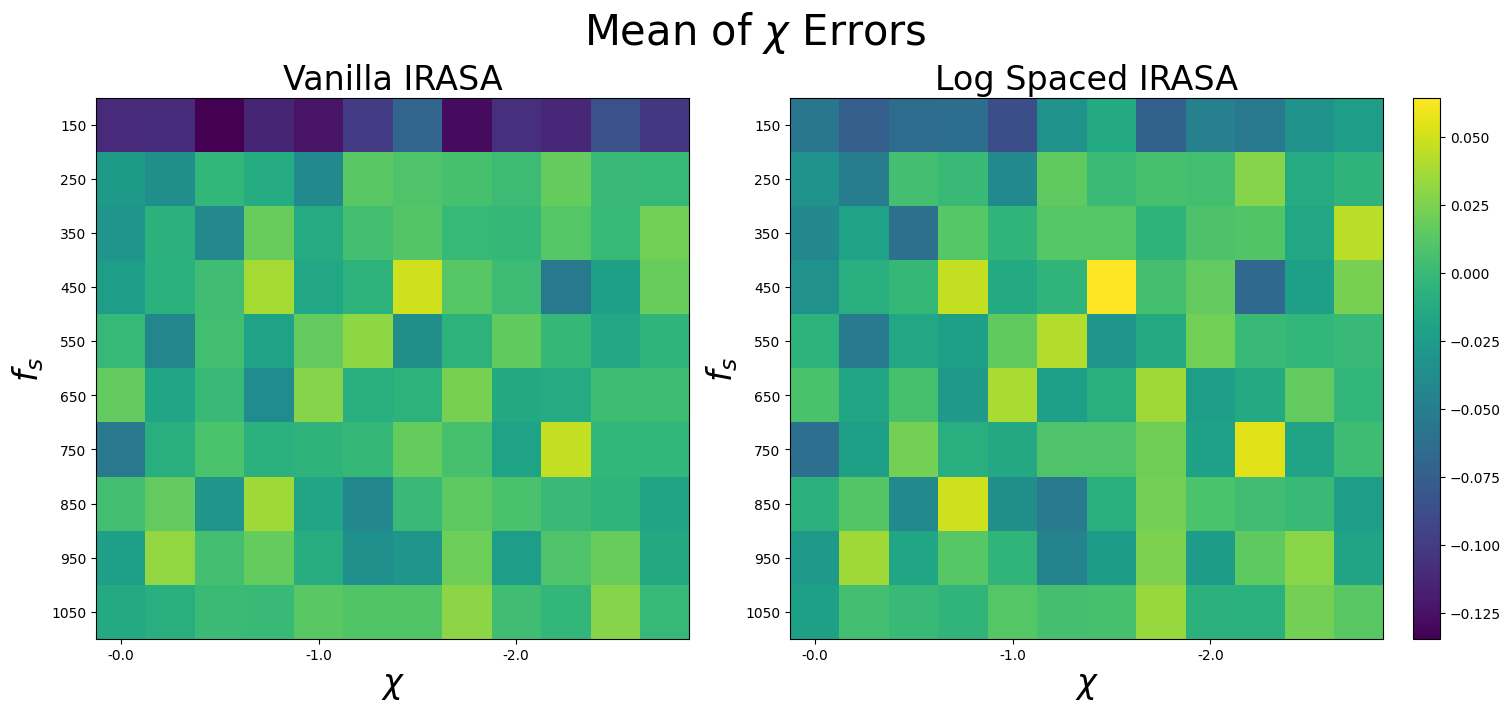

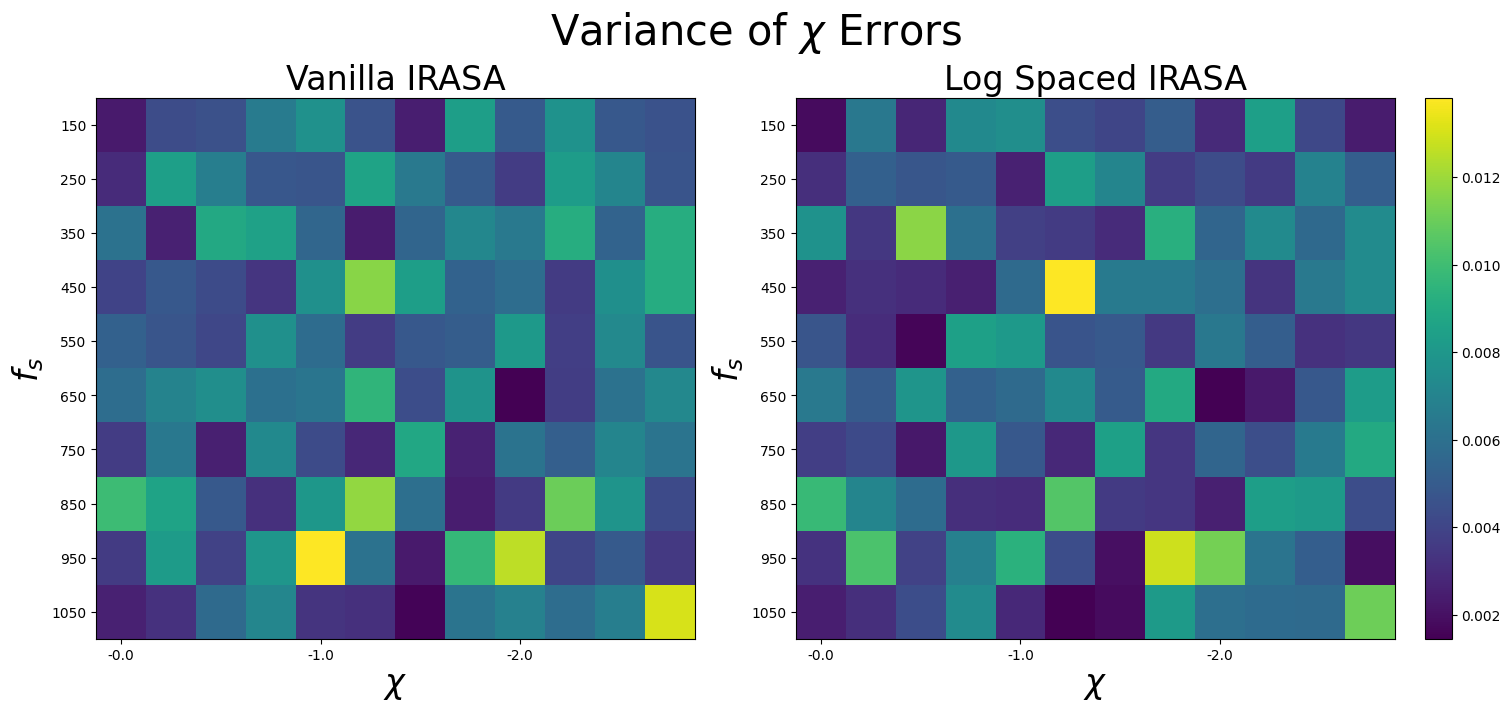

In [8]:
##  Vanilla IRASA Heat Maps
fig, axes = plt.subplots(1, 2, figsize=(15, 7), constrained_layout=True)
fig.suptitle(r"Mean of $\chi$ Errors", fontsize=30)

# Grab the dynamic range of both mean errors
vmin = min(mean_errs_df.min().min(), mean_errs_df_log.min().min())
vmax = max(mean_errs_df.max().max(), mean_errs_df_log.max().max())

# Plot mean errors for both IRASAs
cax_mean = axes[0].matshow(mean_errs_df, aspect='auto', vmin=vmin, vmax=vmax)
axes[0].set_xlabel(r"$\chi$", fontsize=24)
axes[0].set_ylabel(r"$f_s$", fontsize=24)
axes[0].set_title("Vanilla IRASA", fontsize=24)
axes[0].tick_params(which='major', labelsize=10, labelbottom=True, 
                    bottom=True, top=False, labeltop=False)

# Plot mean errors for vanilla IRASA
cax_mean2 = axes[1].matshow(mean_errs_df_log, aspect='auto', vmin=vmin, vmax=vmax)
axes[1].set_xlabel(r"$\chi$", fontsize=24)
axes[1].set_ylabel(r"$f_s$", fontsize=24)
axes[1].set_title("Log Spaced IRASA", fontsize=24)
axes[1].tick_params(which='major', labelsize=10, labelbottom=True, 
                    bottom=True, top=False, labeltop=False)

fig.colorbar(cax_mean2)

# Set tick marks and tick labels
plt.setp(axes, xticks=[idx for idx in range(0, CHIS.shape[0], 4)],
         xticklabels=[CHIS[idx] for idx in range(0, CHIS.shape[0], 4)],
         yticks=[idx for idx in range(0, FS_RANGE.shape[0])],
         yticklabels=[FS_RANGE[idx] for idx in range(0, FS_RANGE.shape[0])]);
  
##  Log spaced IRASA Heat Maps
fig, axes = plt.subplots(1,2, figsize = (15,7), constrained_layout=True)
fig.suptitle("Variance of $\chi$ Errors", fontsize=30)

# Grab the dynamic range of both mean errors
vmin = min(vars_df.min().min(), vars_df_log.min().min())
vmax = max(vars_df.max().max(), vars_df_log.max().max())

#Plot variances for vanilla IRASA
cax_var = axes[0].matshow(vars_df, aspect='auto')
axes[0].set_xlabel(r"$\chi$", fontsize=24)
axes[0].set_ylabel(r"$f_s$", fontsize=24)
axes[0].set_title("Vanilla IRASA", fontsize=24)
axes[0].tick_params(which='major', labelsize=10, labelbottom=True, 
                    bottom=True, top=False, labeltop=False)

#Plot variances for vanilla IRASA
cax_var2 = axes[1].matshow(vars_df_log, aspect='auto')
axes[1].set_xlabel(r"$\chi$", fontsize=24)
axes[1].set_ylabel(r"$f_s$", fontsize=24)
axes[1].set_title("Log Spaced IRASA", fontsize=24)
axes[1].tick_params(which='major', labelsize=10, labelbottom=True, 
                    bottom=True, top=False, labeltop=False)

fig.colorbar(cax_var2)

# Set tick marks and tick labels
plt.setp(axes, xticks=[idx for idx in range(0, CHIS.shape[0], 4)],
        xticklabels=[CHIS[idx] for idx in range(0, CHIS.shape[0], 4)],
        yticks=[idx for idx in range(0, FS_RANGE.shape[0])],
        yticklabels=[FS_RANGE[idx] for idx in range(0, FS_RANGE.shape[0])]);

As expected, both versions of IRASA give good estimates $\chi$. 

It is interesting to see that the average error decreases in absolute value once the sampling rate is greater than or equal to 250Hz for vanilla IRASA, whereas the log spaced IRASA seems to have a better performance when the sampling rate is 150Hz. Otherwise, the two are almost identical.

## Aperiodic + 1 Sinusoid

Next, we see how the two versions of IRASA perform when we add one sinusoid to the aperiodic component. 

Instead of looking at the error as a function of $\chi$ and $f_s$, we will now look at it as a function of $\chi$ and the frequency of the oscillation. 

As before, we look at the average error and the variance of the error across multiple trials because of the randomness in generating the aperiodic component.

In [9]:
# Configure the dataframes
parameter_grid = list(product(CHIS, FREQS, range(NUM_TRIALS)))
num_rows = len(parameter_grid)
columns = ['chi', 'freq', 'trial', 'chi_err']
df = pd.DataFrame(data=np.zeros((num_rows, len(columns))), columns=columns)
df[columns[:-1]] = parameter_grid
df_log = pd.DataFrame(data=np.zeros((num_rows, len(columns))), columns=columns)
df_log[columns[:-1]] = parameter_grid

In [10]:
# Set random seed
np.random.seed(0)

# Run the experiment
tic = time()
for chi, freq, trial_idx in product(CHIS, FREQS, range(NUM_TRIALS)):
    irasa_exp = multiple_sines_trial(N_SECONDS, FS, chi, [freq], F_RANGE)
    irasa_exp_logspace = multiple_sines_trial(N_SECONDS, FS, chi, [freq], F_RANGE, log_space_irasa=True)
    
    loc_mask = (df['chi'] == chi) & (df['freq'] == freq) & (df['trial'] == trial_idx)
    df.loc[loc_mask, 'chi_err'] = irasa_exp - chi
    df_log.loc[loc_mask, 'chi_err'] = irasa_exp_logspace - chi
toc = time()
print(f"{toc-tic:.2f} seconds")

197.60 seconds


In [11]:
# Make a dataframe of average errors and keep track of the variances as well
mean_var_df = df.groupby(by=['chi', 'freq']).agg({'chi_err': ['mean', 'std']})

# Get rid of the top level of column label to make pivoting easier
mean_var_df.columns = mean_var_df.columns.droplevel()

# Finally, flatten the index
mean_var_df = pd.DataFrame(mean_var_df.to_records())
mean_var_df_log = df_log.groupby(by=['chi', 'freq']).agg({'chi_err': ['mean', 'std']})
mean_var_df_log.columns = mean_var_df_log.columns.droplevel()
mean_var_df_log = pd.DataFrame(mean_var_df_log.to_records())

# Pivot to get a matrix of mean errors and variances
mean_errs_df = mean_var_df.set_index(['chi', 'freq'])['mean'].unstack(0)
vars_df = mean_var_df.set_index(['chi', 'freq'])['std'].unstack(0) ** 2
mean_errs_df_log = mean_var_df_log.set_index(['chi', 'freq'])['mean'].unstack(0)
vars_df_log = mean_var_df_log.set_index(['chi', 'freq'])['std'].unstack(0) ** 2

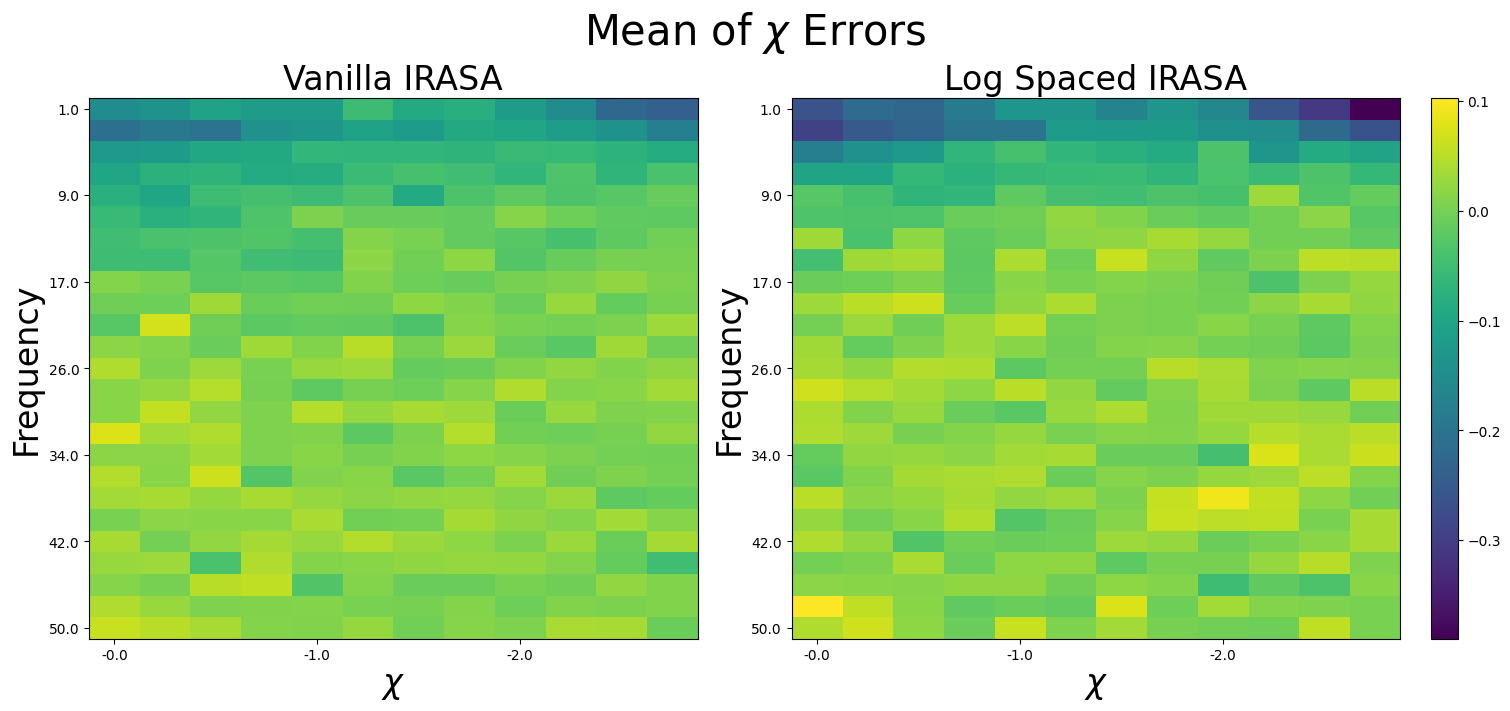

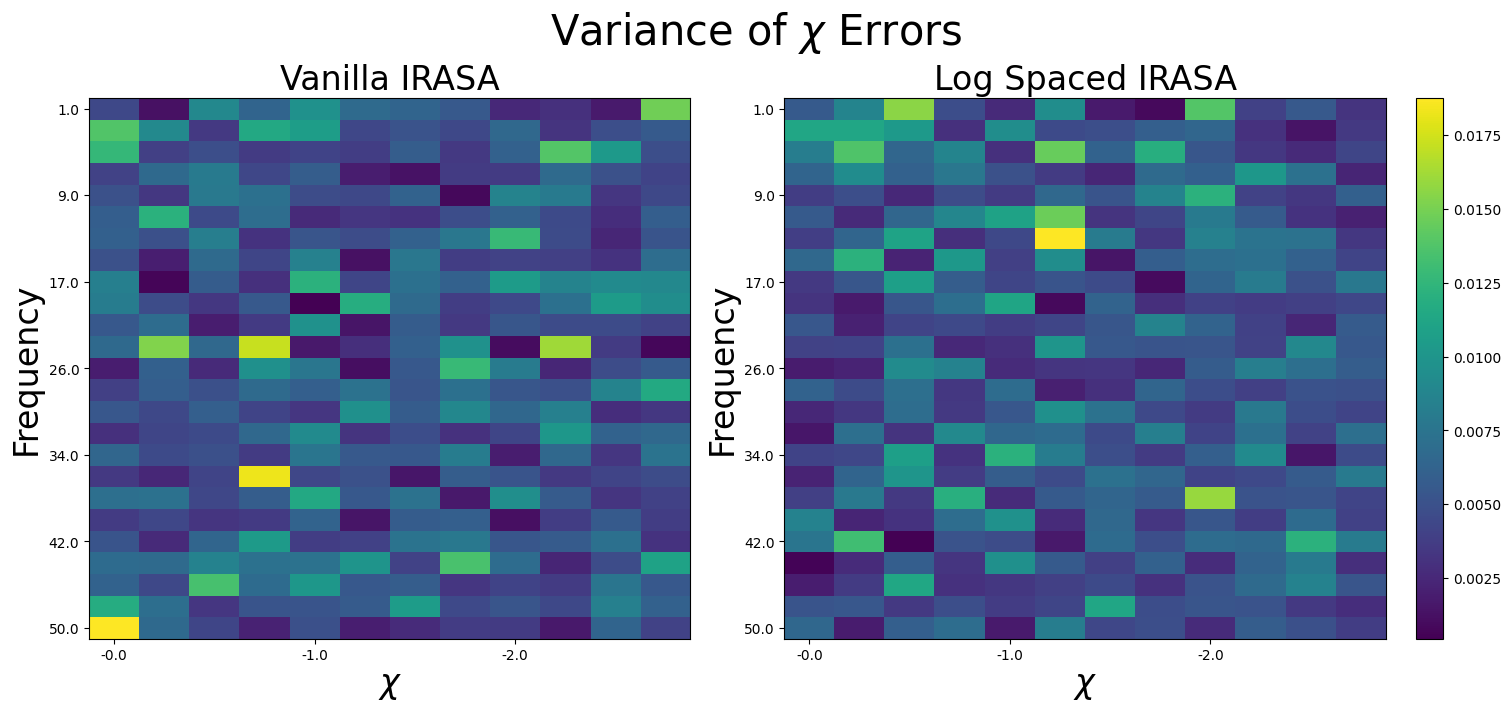

In [12]:
##  Vanilla IRASA Heat Maps
fig, axes = plt.subplots(1, 2, figsize = (15,7), constrained_layout=True)
fig.suptitle("Mean of $\chi$ Errors", fontsize=30)

# Grab the dynamic range of both mean errors
vmin = min(mean_errs_df.min().min(), mean_errs_df_log.min().min())
vmax = max(mean_errs_df.max().max(), mean_errs_df_log.max().max())

# Plot mean errors for both IRASAs
cax_mean = axes[0].matshow(mean_errs_df, aspect='auto', vmin=vmin, vmax=vmax)
axes[0].set_xlabel(r"$\chi$", fontsize=24)
axes[0].set_ylabel("Frequency", fontsize=24)
axes[0].set_title("Vanilla IRASA", fontsize=24)
axes[0].tick_params(which='major', labelsize=10, labelbottom=True, 
                    bottom=True, top=False, labeltop=False)

# Plot mean errors for vanilla IRASA
cax_mean2 = axes[1].matshow(mean_errs_df_log, aspect='auto', vmin=vmin, vmax=vmax)
axes[1].set_xlabel(r"$\chi$", fontsize=24)
axes[1].set_ylabel("Frequency", fontsize=24)
axes[1].set_title("Log Spaced IRASA", fontsize=24)
axes[1].tick_params(which='major', labelsize=10, labelbottom=True, 
                    bottom=True, top=False, labeltop=False)
fig.colorbar(cax_mean2)

# Set tick marks and tick labels
plt.setp(axes, xticks=[idx for idx in range(0, CHIS.shape[0], 4)],
         xticklabels=[CHIS[idx] for idx in range(0, CHIS.shape[0], 4)],
         yticks=[idx for idx in range(0, FREQS.shape[0], 4)],
         yticklabels=[FREQS[idx] for idx in range(0, FREQS.shape[0], 4)]);
   
##  Log spaced IRASA Heat Maps
fig, axes = plt.subplots(1,2, figsize = (15,7), constrained_layout=True)
fig.suptitle("Variance of $\chi$ Errors", fontsize=30)

# Grab the dynamic range of both mean errors
vmin = min(vars_df.min().min(), vars_df_log.min().min())
vmax = max(vars_df.max().max(), vars_df_log.max().max())

#Plot variances for vanilla IRASA
cax_var = axes[0].matshow(vars_df, aspect='auto')
axes[0].set_xlabel(r"$\chi$", fontsize=24)
axes[0].set_ylabel("Frequency", fontsize=24)
axes[0].set_title("Vanilla IRASA", fontsize=24)
axes[0].tick_params(which='major', labelsize=10, labelbottom=True, 
                    bottom=True, top=False, labeltop=False)

#Plot variances for vanilla IRASA
cax_var2 = axes[1].matshow(vars_df_log, aspect='auto')
axes[1].set_xlabel(r"$\chi$", fontsize=24)
axes[1].set_ylabel("Frequency", fontsize=24)
axes[1].set_title("Log Spaced IRASA", fontsize=24)
axes[1].tick_params(which='major', labelsize=10, labelbottom=True, 
                    bottom=True, top=False, labeltop=False)
fig.colorbar(cax_var2)

# Set tick marks and tick labels
plt.setp(axes, xticks=[idx for idx in range(0, CHIS.shape[0], 4)],
         xticklabels=[CHIS[idx] for idx in range(0, CHIS.shape[0], 4)],
         yticks=[idx for idx in range(0, FREQS.shape[0], 4)],
         yticklabels=[FREQS[idx] for idx in range(0, FREQS.shape[0], 4)]);

Once again, these results are totally unsurprising. IRASA was built to succeed in the setting where there are only very few oscillations.

## Aperiodic + 4 Well-Spaced Sinusoids (Not sure about this experiment anymore)

IRASA does well with more than one simple oscillatory component provided the frequencies of the sinusoids are sufficiently far apart.

In [15]:
# # Configure the dataframes
# parameter_grid = list(product(CHIS, FREQS, range(NUM_TRIALS)))
# num_rows = len(parameter_grid)
# columns = ['chi', 'freq', 'trial', 'chi_err']
# df = pd.DataFrame(data=np.zeros((num_rows, len(columns))), columns=columns)
# df[columns[:-1]] = parameter_grid
# df_log = pd.DataFrame(data=np.zeros((num_rows, len(columns))), columns=columns)
# df_log[columns[:-1]] = parameter_grid

In [16]:
# df = pd.DataFrame(data=np.zeros((len(FREQS), CHIS.shape[0])), index=FREQS, columns=CHIS)
# df_log = pd.DataFrame(data=np.zeros((len(FREQS), CHIS.shape[0])), index=FREQS, columns=CHIS)
# tic = time()
# for chi, freq, trial_idx in product(CHIS, FREQS, range(NUM_TRIALS)):
    
#     # Here, take 4 equispaced frequencies in log space between freq and the maximum frequency in F_RANGE.
#     sine_freqs = log_space_freqs(np.arange(freq, F_RANGE[1]), 4)
    
#     # Estimate chi
#     irasa_exp = multiple_sines_trial(N_SECONDS, FS, chi, sine_freqs, F_RANGE)
#     irasa_exp_logspace = multiple_sines_trial(N_SECONDS, FS, chi, sine_freqs, F_RANGE, log_space_irasa=True)
#     df.loc[freq][chi] += np.abs(chi - irasa_exp)
#     df_log.loc[freq][chi] += np.abs(chi - irasa_exp_logspace)
    
# toc = time()
# print(f"{toc-tic:.2f} seconds")
# df /= NUM_TRIALS

In [17]:
# # Matrix plot
# fig, axes = plt.subplots(1,2, figsize = (15,7))
# cax = axes[0].matshow(df, aspect='auto')
# cax2 = axes[1].matshow(df_log, aspect='auto')
# axes[0].set_xlabel(r"$\chi$", fontsize=24)
# axes[0].set_ylabel("Frequency", fontsize=24)
# axes[1].set_xlabel(r"$\chi$", fontsize=24)
# axes[1].set_ylabel("Frequency", fontsize=24)
# plt.setp(axes, xticks=[idx for idx in range(0, CHIS.shape[0], 4)],
#          xticklabels=[CHIS[idx] for idx in range(0, CHIS.shape[0], 4)],
#          yticks=[idx for idx in range(0, len(FREQS))],
#          yticklabels=[FREQS[idx] for idx in range(0, len(FREQS))])
# fig.suptitle(r"Absolute Error in Estimating $\chi$", fontsize=30)
# axes[0].set_title("Vanilla IRASA", fontsize=24)
# axes[1].set_title("Log Spaced IRASA", fontsize=24)
# fig.tight_layout(pad=5.0)
# fig.colorbar(cax)

## Aperiodic + Cluster of Sinusoids (seems redundant with central frequency)

However, IRASA does have difficulties when there are multiple sinusoids whose frequencies are close to one another. 

Below, we superimpose an aperiodic component with a sum of sinusoids whose frequencies span a length of 0.5 in logarithmic spacing of frequencies.

In [18]:
df = pd.DataFrame(data=np.zeros((len(FREQS), CHIS.shape[0])), index=FREQS, columns=CHIS)
df_log = pd.DataFrame(data=np.zeros((len(FREQS), CHIS.shape[0])), index=FREQS, columns=CHIS)
bw = 0.5
tic = time()
for chi, freq, trial_idx in product(CHIS, FREQS, range(NUM_TRIALS)):
    # Sum sinusoids of frequencies whose bandwidth is bw in log space of frequencies.
    f_end = round(10**(bw + np.log10(freq)))
    sine_freqs = [freq for freq in np.arange(freq, f_end, 1./N_SECONDS)]
    irasa_exp = multiple_sines_trial(N_SECONDS, FS, chi, sine_freqs, F_RANGE)
    irasa_exp_logspace = multiple_sines_trial(N_SECONDS, FS, chi, sine_freqs, F_RANGE, log_space_irasa=True)
    df.loc[freq][chi] += np.abs(chi - irasa_exp)
    df_log.loc[freq][chi] += np.abs(chi - irasa_exp_logspace)
toc = time()
print(f"{toc-tic:.2f} seconds")
df /= NUM_TRIALS

1196.96 seconds


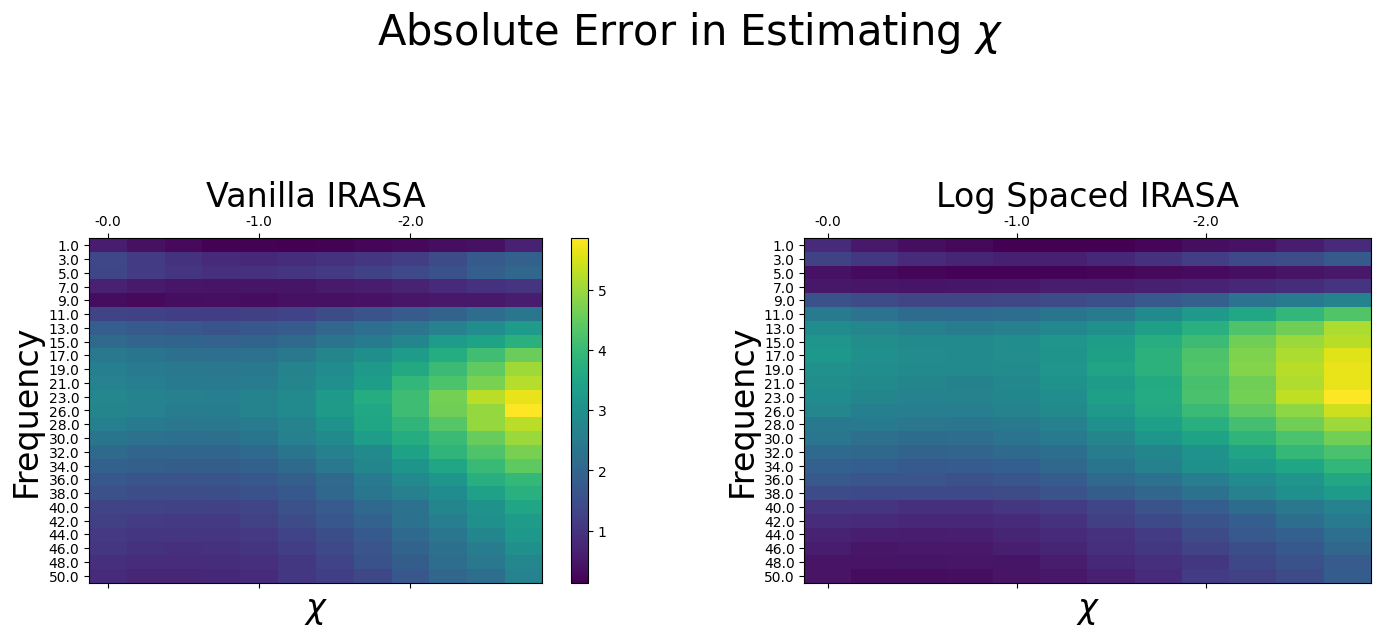

In [19]:
# Matrix plot
fig, axes = plt.subplots(1,2, figsize = (15,7))
cax = axes[0].matshow(df, aspect='auto')
cax2 = axes[1].matshow(df_log, aspect='auto')
axes[0].set_xlabel(r"$\chi$", fontsize=24)
axes[0].set_ylabel("Frequency", fontsize=24)
axes[1].set_xlabel(r"$\chi$", fontsize=24)
axes[1].set_ylabel("Frequency", fontsize=24)
plt.setp(axes, xticks=[idx for idx in range(0, CHIS.shape[0], 4)],
         xticklabels=[CHIS[idx] for idx in range(0, CHIS.shape[0], 4)],
         yticks=[idx for idx in range(0, len(FREQS))],
         yticklabels=[FREQS[idx] for idx in range(0, len(FREQS))])
fig.suptitle(r"Absolute Error in Estimating $\chi$", fontsize=30)
axes[0].set_title("Vanilla IRASA", fontsize=24)
axes[1].set_title("Log Spaced IRASA", fontsize=24)
fig.tight_layout(pad=5.0)
fig.colorbar(cax)

## Aperiodic with Central Frequency

Now we'll test how IRASA performs on signals with an oscillatory and aperiodic component as in the context of FOOOF where there is a central frequency with a pre-defined bandwidth and relative height above the aperiodic component. 

Here, we'll look at the error as a function of $\chi$, the central_frequency, the bandwidth, and the relative height. 

This experiment takes a very long time to run because there are so many parameters to run experiments over. To look at the results of one instance of this experiment, you can run the cell that loads the dataframe from a csv file.

In [21]:
# Set constants for this particular experiment
HEIGHTS = np.linspace(2, 4, num=3) ## in 10**Hz 
BANDWIDTHS = np.linspace(3, 12, 4) ## in Hz

parameter_grid = list(product(CHIS, FREQS, HEIGHTS, BANDWIDTHS, range(NUM_TRIALS)))
num_rows = NUM_TRIALS*HEIGHTS.shape[0]*BANDWIDTHS.shape[0]*FREQS.shape[0]*CHIS.shape[0]

columns = np.array(['chi', 'central_freq', 'rel_height', 'bandwidth', 'trial', 'chi_err'])
df = pd.DataFrame(data=np.zeros((num_rows, columns.shape[0])), columns=columns)
df[columns[:-1]] = parameter_grid

In [22]:
# Set random seed
np.random.seed(0)

In [26]:
sim_peak_oscillation??

In [23]:
tic = time()
fit_exps = parallel_func(parameter_grid=parameter_grid)
for irasa_exp, (chi, central_freq, ht, bw, trial) in zip(fit_exps, parameter_grid):
    loc_mask = (df['chi'] == chi) & (df['central_freq'] == central_freq) & \
        (df['rel_height'] == ht) & (df['bandwidth'] == bw) & (df['trial'] == trial)
    df.loc[loc_mask]['chi_err'] = irasa_exp-chi
toc = time()
print(f"{toc-tic:.2f} seconds")

NameError: name 'sim_central_freq' is not defined

In [20]:
# # Alternatively, load the data from the csv file
# df = pd.read_csv('./full_central_freq_IRASA_experiment2.csv')

In [ ]:
# Make a dataframe of average errors and keep track of the variances as well
mean_var_df = df.groupby(by=['chi', 'central_freq', 'rel_height', 'bandwidth']).agg({'chi_err': ['mean', 'std']})

# Get rid of the top level of column label to make pivoting easier
mean_var_df.columns = mean_var_df.columns.droplevel()

# Finally, flatten the index
mean_var_df = pd.DataFrame(mean_var_df.to_records())

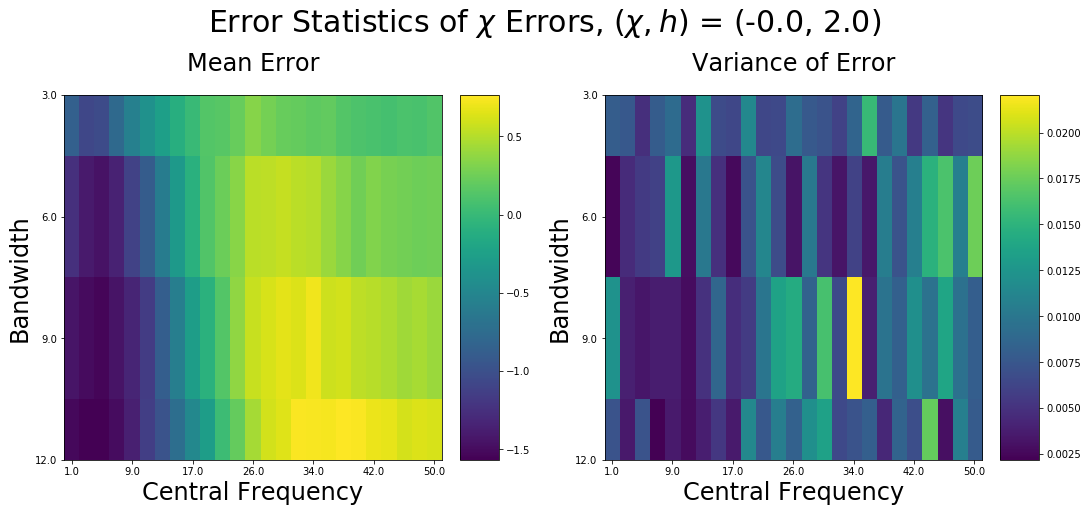

In [23]:
plot_chis = [CHIS[0]]
plot_heights = [HEIGHTS[0],]

for chi in plot_chis:
    for ht_idx, ht in enumerate(plot_heights):
        
        loc_mask = (mean_var_df['chi'] == chi) & (mean_var_df['rel_height'] == ht)
        
        # Subselect only those rows for which the chi and the relative height are fixed.
        temp_df = mean_var_df.loc[loc_mask, ['central_freq', 'bandwidth', 'mean', 'std']]

        # Pivot to get a matrix of mean errors and variances
        mean_errs_df = temp_df.set_index(['central_freq', 'bandwidth'])['mean'].unstack(0)
        vars_df = temp_df.set_index(['central_freq', 'bandwidth'])['std'].unstack(0) ** 2
   
        ##  Vanilla IRASA Heat Maps

        fig, axes = plt.subplots(1,2, figsize = (15,7), constrained_layout=True)

        fig.suptitle(rf"Error Statistics of $\chi$ Errors, $(\chi, h)$ = ({chi}, {ht})", fontsize=30)

        # Grab the dynamic range of mean errors and variances
        vmin_mean = mean_errs_df.min().min()
        vmax_mean = mean_errs_df.max().max()
        
        vmin_var = vars_df.min().min()
        vmax_var = vars_df.max().max()

        # Plot mean errors
        cax_mean = axes[0].matshow(mean_errs_df, aspect='auto', vmin=vmin_mean, vmax=vmax_mean)
        axes[0].set_xlabel("Central Frequency", fontsize=24)
        axes[0].set_ylabel("Bandwidth", fontsize=24)
        axes[0].set_title("Mean Error", fontsize=24)
        axes[0].tick_params(which='major', labelsize=10, labelbottom=True,
                            bottom=True, top=False, labeltop=False)
        fig.colorbar(cax_mean, ax=axes[0])
    
        # Plot variance of errors
        cax_var = axes[1].matshow(vars_df, aspect='auto', vmin=vmin_var, vmax=vmax_var)
        axes[1].set_xlabel("Central Frequency", fontsize=24)
        axes[1].set_ylabel("Bandwidth", fontsize=24)
        axes[1].set_title("Variance of Error", fontsize=24)
        axes[1].tick_params(which='major', labelsize=10, labelbottom=True,
                            bottom=True, top=False, labeltop=False)
        fig.colorbar(cax_var, ax=axes[1])

        # Set tick marks and tick labels
        plt.setp(axes, xticks=[idx for idx in range(0, FREQS.shape[0], 4)],
                 xticklabels=[FREQS[idx] for idx in range(0, FREQS.shape[0], 4)],
                 yticks=[idx for idx in range(0, BANDWIDTHS.shape[0])],
                 yticklabels=[BANDWIDTHS[idx] for idx in range(0, BANDWIDTHS.shape[0])]);

## Closer Look: Low Frequency Central Frequencies

IRASA seems to perform worse at estimating the power law exponent when the relative height and bandwidth of the central frequency are large, especially so when the central frequency is a low frequency oscillation. The data suggest two conclusions:  
    
1. all else constant, the effect of $\chi$ is minimal on the mean error and the variance of the error, and  
2. for low frequency central frequencies, there is a negative bias in estimating $\chi$. 
    
The negative bias in estimating $\chi$ is unsurprising, as we expect such a bump in  to artificially inflate the ceptstrum even after IRASA attempts to average it out. This inflated estimate of the power naturally affects the slope of the cepstrum by making it steeper. Indeed, we see this in various instances of such a signal.

In [ ]:
chi = -1.5
central_freq = 10   # In Hz
bandwidth = 2       # In Hz
rel_height = 4      # In 10**Hz
times = create_times(N_SECONDS, FS)

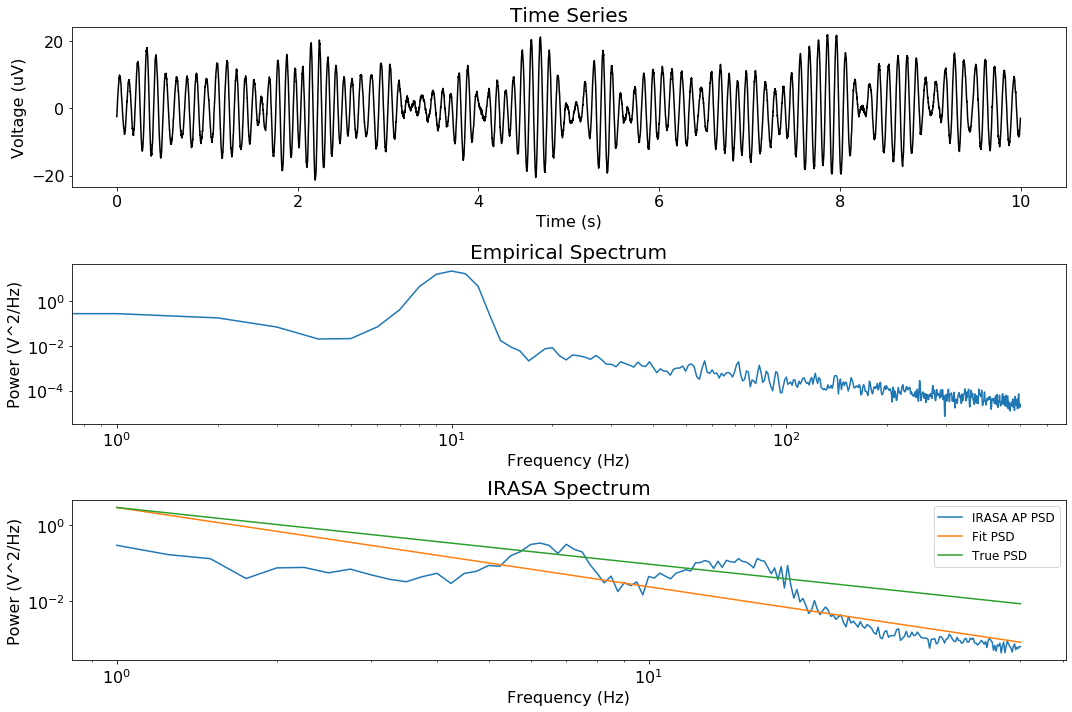

In [17]:
fig, axes = plt.subplots(3,1, figsize=(15, 10))
axes[0].set_title("Time Series", fontsize=20)
axes[1].set_title("Empirical Spectrum", fontsize=20)
axes[2].set_title("IRASA Spectrum", fontsize=20)

sig = sim_central_freq(N_SECONDS, FS, chi, central_freq, bandwidth, rel_height)
plot_time_series(times, sig, ax=axes[0])
freqs, psd = compute_spectrum(sig, FS)
plot_power_spectra(freqs, psd, ax=axes[1])

irasa_params = {'fs' : FS, 'f_range' : F_RANGE}
freqs_irasa, psd_ap, psd_pe = compute_irasa(sig, **irasa_params)
fit_offset, fit_chi = fit_irasa(freqs_irasa,psd_ap)

true_psd = freqs_irasa**chi
fit_psd = 10**fit_offset*freqs_irasa**fit_chi 

# Normalize to match intercept with curve fitted irasa PSD
true_psd = fit_psd[0]/true_psd[0] * true_psd
plot_power_spectra(freqs_irasa, [psd_ap, fit_psd, true_psd],
                   labels=["IRASA AP PSD", "Fit PSD", "True PSD"], ax=axes[2])

## Closer Look: High Frequency Central Frequency

In contrast to the low frequency setting, when the central frequency is a high frequency oscillation we expect this bump to artificially push the powers of the high frequency up, even after IRASA tries to average the central frequency out. Consequentially, this will lead to an estimated $\chi$ which is smaller in absolute value than the true value. And indeed, this is the case for various instances of such a signal.

In [ ]:
chi = -1.5
central_freq = 32  # In Hz
bandwidth = 2      # In Hz
rel_height = 4     # In 10**Hz
times = create_times(N_SECONDS, FS)

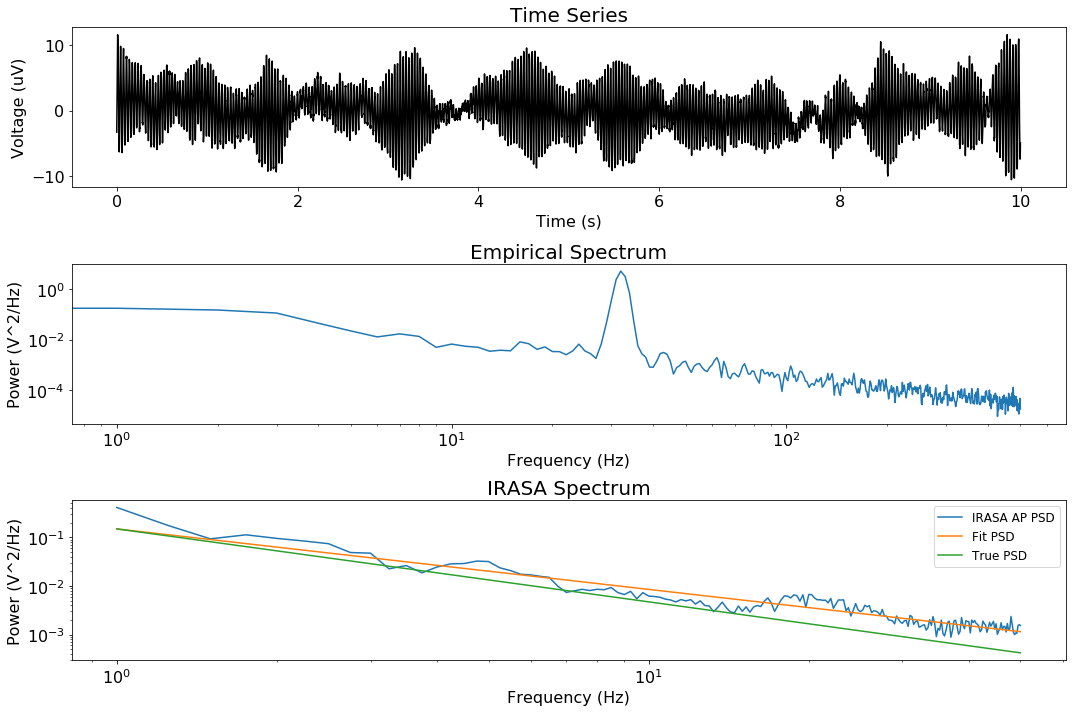

In [19]:
fig, axes = plt.subplots(3,1, figsize=(15, 10))
axes[0].set_title("Time Series", fontsize=20)
axes[1].set_title("Empirical Spectrum", fontsize=20)
axes[2].set_title("IRASA Spectrum", fontsize=20)

sig = sim_central_freq(N_SECONDS, FS, chi, central_freq, bandwidth, rel_height)
plot_time_series(times, sig, ax=axes[0])
freqs, psd = compute_spectrum(sig, FS)
plot_power_spectra(freqs, psd, ax=axes[1])

irasa_params = {'fs' : FS, 'f_range' : F_RANGE}
freqs_irasa, psd_ap, psd_pe = compute_irasa(sig, **irasa_params)
fit_offset, fit_chi = fit_irasa(freqs_irasa,psd_ap)

true_psd = freqs_irasa**chi
fit_psd = 10**fit_offset*freqs_irasa**fit_chi 

# Normalize to match intercept with curve fitted irasa PSD
true_psd = fit_psd[0]/true_psd[0] * true_psd
plot_power_spectra(freqs_irasa, [psd_ap, fit_psd, true_psd],
                   labels=["IRASA AP PSD", "Fit PSD", "True PSD"], ax=axes[2])

## Aperiodic Noise with Knee

Now let's take a look at how IRASA behaves on aperiodic noise with no oscillations when the power spectrum follows a knee model. 

Here, we have three parameters to estimate: the knee, and the two power laws. 

In the below experiments, we look at estimating only the power law exponents. Further, we only look at those cases in which the exponent of the second half of the knee does not exceed 3.

In [25]:
# Set constants for this particular experiment
# Only choose pairs of chis for which the slope of the second half of the knee is steeper than the first.
# NOTE: The knee simulation uses the convention that chi's are **positive** whereas neurodsp uses negative chis.
# So use positive chi pairs here.

CHI_PAIRS = np.array([(chi1, chi2) for chi1, chi2 in product(-CHIS, -CHIS) if chi1 + chi2 < 3])

KNEES = np.arange(0, 100, 10)

parameter_grid = [(chi1, chi2, knee, trial) for (chi1, chi2), knee, trial in product(CHI_PAIRS, KNEES, range(NUM_TRIALS))]

num_rows = CHI_PAIRS.shape[0]*KNEES.shape[0]*NUM_TRIALS

df = pd.DataFrame(data=np.zeros((num_rows,7)),
                  columns=["chi1", "chi2", "knee", "trial", "err_chi1", "err_chi2", "err_knee"])
df[['chi1', 'chi2', 'knee', 'trial']] = parameter_grid

In [ ]:
# Set random seed
np.random.seed(0)

In [26]:
tic = time()
for chi1, chi2, knee, trial_idx in parameter_grid:
    fit_chi1, fit_chi2, fit_knee = knee_trial(N_SECONDS, FS, f_range=F_RANGE, chi1=chi1, chi2=chi2, k=knee)
    loc_mask = (df['chi1'] == chi1) & (df['chi2'] == chi2) & (df['knee'] == knee) & (df['trial'] == trial_idx)
    df.loc[loc_mask, 'err_chi1'] = fit_chi1 - chi1
    df.loc[loc_mask, 'err_chi2'] = fit_chi2 - chi2
    df.loc[loc_mask, 'err_knee'] = fit_knee - knee
toc = time()
print(f"{toc-tic:.2f} seconds")

3148.37 seconds


In [31]:
# Load the dataframe from file
df = pd.read_csv("full_knee_experiment.csv")

### Visualizing the Errors

As before, we'll take a look at the mean error and the variance of the errors as heatmaps where we let $\chi_1$, $\chi_2$ range over their possible values and for a fixed knee. 

If you would like to see more or less heat maps, you may modify the `plot_knees` variable below.

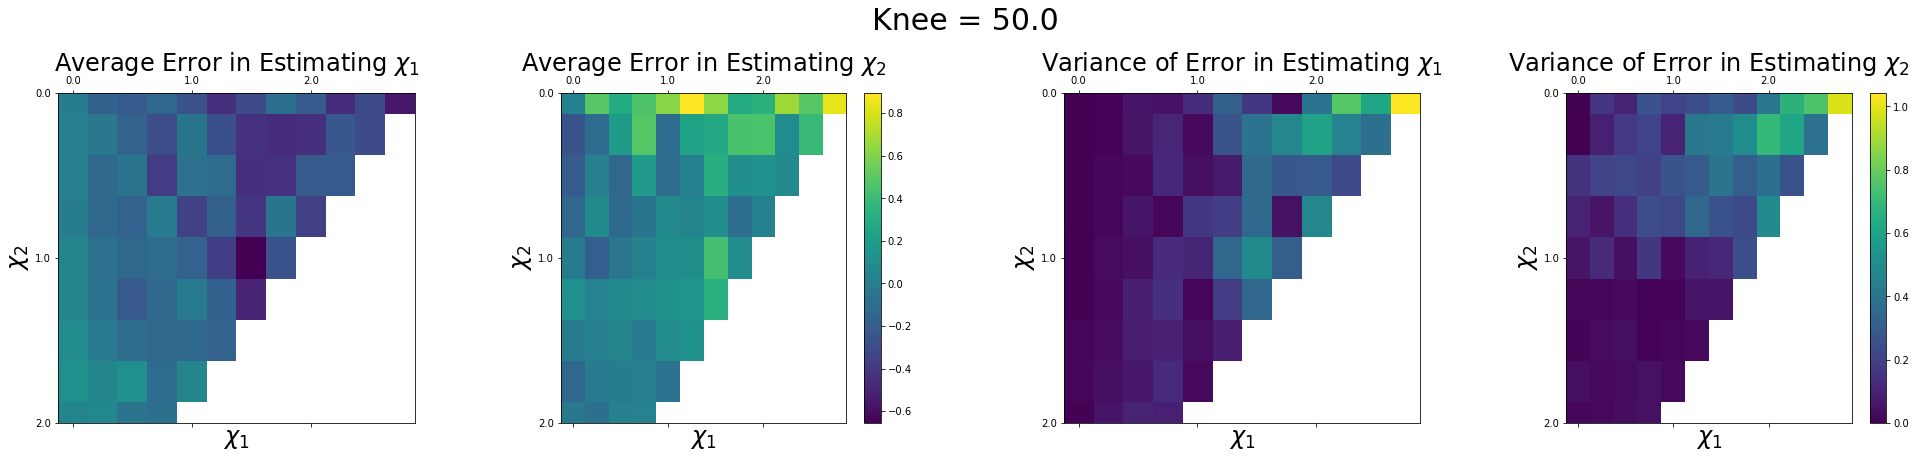

In [41]:
plot_knees = [KNEES[5],]

mean_var_df = df.groupby(by=['chi1', 'chi2', 'knee']).agg({'err_chi1': ['mean', 'std'],
                                                           'err_chi2': ['mean', 'std'],
                                                           'err_knee': ['mean', 'std']})
mean_var_df = pd.DataFrame(mean_var_df.to_records())
mean_var_df.columns = ['chi1', 'chi2', 'knee', 'err_chi1_mean', 'err_chi1_std',
                       'err_chi2_mean', 'err_chi2_std', 'err_knee_mean', 'err_knee_std']

for knee in plot_knees:
    fig, axes = plt.subplots(1,4, figsize = (28,7))
    
    # Grab the dynamic range of the absolute errors so the heatmaps share a colorbar.
    vmin_mean = mean_var_df.loc[mean_var_df['knee']==knee, ['err_chi1_mean',  'err_chi2_mean']].min().min()
    vmax_mean = mean_var_df.loc[mean_var_df['knee']==knee, ['err_chi1_mean', 'err_chi2_mean']].max().max()
    
    vmin_var = mean_var_df.loc[mean_var_df['knee']==knee, ['err_chi1_std',  'err_chi2_std']].min().min()**2
    vmax_var = mean_var_df.loc[mean_var_df['knee']==knee, ['err_chi1_std', 'err_chi2_std']].max().max()**2
    
    for idx, ax in enumerate(axes.ravel()):
        
        # Grab only the ch1, chi2, and err_chi columns
        if idx == 0:
            ax.set_title(rf"Average Error in Estimating $\chi_1$", fontsize=24)
            # Plot err_chi1_mean heatmap
            chi_mat_errs = mean_var_df.loc[mean_var_df['knee'] == knee, ['chi1', 'chi2', 'err_chi1_mean']]
            # Pivot chi1 column
            chi_mat_errs = chi_mat_errs.set_index(['chi1', 'chi2']).err_chi1_mean.unstack(0)
        elif idx == 1:
            ax.set_title(rf"Average Error in Estimating $\chi_2$", fontsize=24)
            chi_mat_errs = mean_var_df.loc[mean_var_df['knee'] == knee, ['chi1', 'chi2', 'err_chi2_mean']]
            # Pivot chi1 column
            chi_mat_errs = chi_mat_errs.set_index(['chi1', 'chi2']).err_chi2_mean.unstack(0)
        elif idx == 2:
            ax.set_title(rf"Variance of Error in Estimating $\chi_1$", fontsize=24)
            chi_mat_errs = mean_var_df.loc[mean_var_df['knee'] == knee, ['chi1', 'chi2', 'err_chi1_std']]
            # Pivot chi1 column
            chi_mat_errs = chi_mat_errs.set_index(['chi1', 'chi2']).err_chi1_std.unstack(0)**2
        else:
            ax.set_title(rf"Variance of Error in Estimating $\chi_2$", fontsize=24)
            chi_mat_errs = mean_var_df.loc[mean_var_df['knee'] == knee, ['chi1', 'chi2', 'err_chi2_std']]
            # Pivot chi1 column
            chi_mat_errs = chi_mat_errs.set_index(['chi1', 'chi2']).err_chi2_std.unstack(0)**2
        
        # Adjust the range for the colorbar based on whether you're plotting means or variances
        cax = ax.matshow(chi_mat_errs, aspect='auto', vmin=vmin_mean, vmax=vmax_mean) \
            if idx < 2 else ax.matshow(chi_mat_errs, aspect='auto', vmin=vmin_var, vmax=vmax_var)
        ax.set_xlabel(r"$\chi_1$", fontsize=24)
        ax.set_ylabel(r"$\chi_2$", fontsize=24)
        
        ticks = [idx for idx in range(0, CHIS.shape[0], 4)]
        ticklabels = [-CHIS[idx] for idx in range(0, CHIS.shape[0], 4)]
        
        plt.setp(ax, xticks=ticks,
                xticklabels=ticklabels,
                yticks=ticks,
                yticklabels=ticklabels)
        if idx in (1, 3): 
            # Add color bar to last mean or variance plot
            fig.colorbar(cax, ax = ax)
    
    fig.suptitle(rf"Knee = {knee:.1f}", fontsize=30)
    fig.tight_layout(pad=5.0)

## Closer Look

It looks like IRASA performs the worst for estimating both $\chi_1$ and $\chi_2$ when the knee is zero. 

This isn't surprising though, because without the knee the two power law exponents combine to form a simple power law. There are infinitely many choices of the two exponents in this case that would yield the same power spectrum.

Another trend thats apparent in the above heat maps is that IRASA seems to perform worse at estimating both exponents in the regime where \(\chi_2\) is near zero and \(\chi_1\) is near 3.

Let's take a detailed look at one example and compare what the true PSD is to what IRASA estimates it to be.

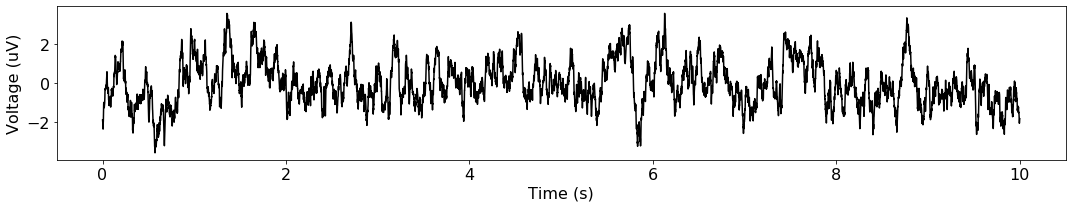

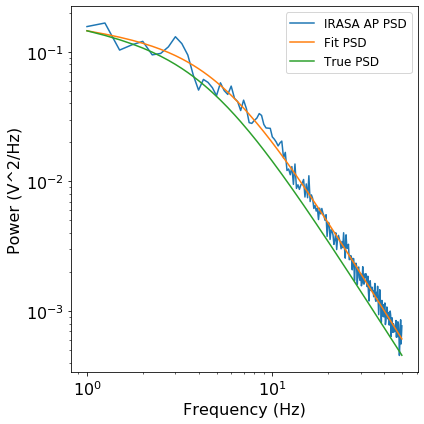

In [24]:
chi1 = 0.25
chi2 = 2
knee = 20.0
times = create_times(N_SECONDS, FS)

sig = sim_knee(N_SECONDS, FS, chi1, chi2, knee)
plot_time_series(times, sig)
freqs, psd = compute_spectrum(sig, FS)

irasa_params = {'fs' : FS, 'f_range' : F_RANGE}
freqs_irasa, psd_ap, psd_pe = compute_irasa(sig, **irasa_params)
fit_offset, fit_chi1, fit_chi2, fit_knee = fit_irasa_knee(freqs_irasa,psd_ap)

true_psd = 1/(freqs_irasa**chi1*(freqs_irasa**chi2 + knee))
fit_psd = fit_offset/(freqs_irasa**fit_chi1 * (freqs_irasa**fit_chi2 + fit_knee))
# Normalize to match intercept with curve fitted irasa PSD
true_psd = fit_psd[0]/true_psd[0] * true_psd
plot_power_spectra(freqs_irasa, [psd_ap, fit_psd, true_psd], labels=["IRASA AP PSD", "Fit PSD", "True PSD"])